In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [2]:
# a) Load BCCD dataset
data, info = tfds.load('bccd', with_info=True, as_supervised=False)
train_ds = data['train']
val_ds = data['validation']
test_ds = data['test']

# b) Show number of images
print("Train:", info.splits['train'].num_examples)
print("Validation:", info.splits['validation'].num_examples)
print("Test:", info.splits['test'].num_examples)


c:\Users\SRIRAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:09<00:00,  5.25s/ url]

Dl Completed...: 100%|██████████| 1/1 [00:10<00:00,  5.25s/ url]

Dl Completed...: 100%|██████████| 1/1 [00:11<00:00,  5.25s/ url]

Extraction completed...: 100%|██████████| 739/739 [00:12<00:00, 60.76 file/s]
Dl Size...: 7 MiB [00:12,  1.74s/ MiB]
Dl Completed...: 100%|██████████| 1/1 [00:12<00:00, 12.17s/ url]


Dataset bccd downloaded and prepared to C:\Users\SRIRAM\tensorflow_datasets\bccd\1.0.0. Subsequent calls will reuse this data.
Train: 205
Validation: 87
Test: 72


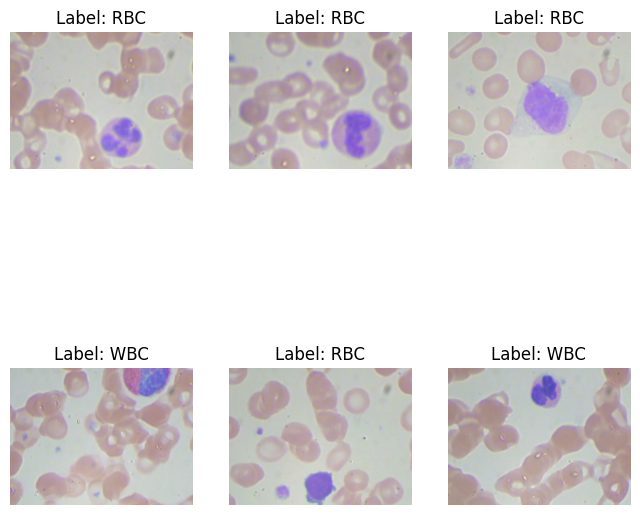

In [3]:
plt.figure(figsize=(8,8))
for i, sample in enumerate(train_ds.take(6)):
    img = sample['image']
    label = sample['objects']['label'][0]  # first object’s label
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f"Label: {info.features['objects'].feature['label'].int2str(label)}")
    plt.axis('off')
plt.show()


In [4]:
def preprocess(sample):
    img = sample['image']
    # If multiple objects, take the first label (just for classification demo)
    label = sample['objects']['label'][0]
    img = tf.image.resize(img, (128, 128))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

train_ds_proc = train_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds_proc = val_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_proc = test_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


In [5]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(info.features['objects'].feature['label'].num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds_proc, validation_data=val_ds_proc, epochs=5)
# Evaluate on test
test_loss, test_acc = model.evaluate(test_ds_proc)
print("Test accuracy before augmentation:", test_acc)


Epoch 1/5


c:\Users\SRIRAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5360 - loss: 1.0780 - val_accuracy: 0.8621 - val_loss: 0.4642
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8058 - loss: 0.5791 - val_accuracy: 0.8621 - val_loss: 0.4530
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8058 - loss: 0.5716 - val_accuracy: 0.8621 - val_loss: 0.4467
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8058 - loss: 0.5625 - val_accuracy: 0.8621 - val_loss: 0.4380
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8058 - loss: 0.5532 - val_accuracy: 0.8621 - val_loss: 0.4358
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7895 - loss: 0.5545
Test accuracy before augmentation: 0.8055555820465088


In [6]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.3)
])

# Directly apply augmentation
aug_train = train_ds_proc.map(lambda x, y: (data_aug(x), y))



In [7]:
# Clone model or reinitialize
aug_model = models.clone_model(model)
aug_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

aug_history = aug_model.fit(aug_train, validation_data=val_ds_proc, epochs=5)
test_loss2, test_acc2 = aug_model.evaluate(test_ds_proc)
print("Test accuracy after augmentation:", test_acc2)


Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.6115 - loss: 1.1241 - val_accuracy: 0.8621 - val_loss: 0.4650
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8058 - loss: 0.6167 - val_accuracy: 0.8621 - val_loss: 0.4471
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8058 - loss: 0.5982 - val_accuracy: 0.8621 - val_loss: 0.4756
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.8058 - loss: 0.5756 - val_accuracy: 0.8621 - val_loss: 0.4430
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.8058 - loss: 0.5756 - val_accuracy: 0.8621 - val_loss: 0.4557
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7895 - loss: 0.5651
Test accuracy after augmentation: 0.8055555820465088


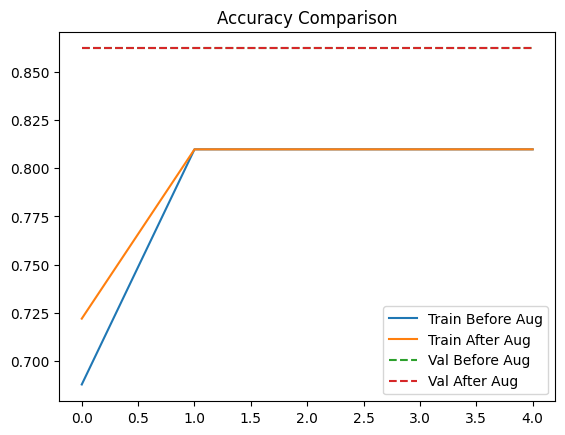

Test accuracy before: 0.8055555820465088
Test accuracy after: 0.8055555820465088


In [8]:
plt.plot(history.history['accuracy'], label='Train Before Aug')
plt.plot(aug_history.history['accuracy'], label='Train After Aug')
plt.plot(history.history['val_accuracy'], '--', label='Val Before Aug')
plt.plot(aug_history.history['val_accuracy'], '--', label='Val After Aug')
plt.title('Accuracy Comparison')
plt.legend()
plt.show()

print("Test accuracy before:", test_acc)
print("Test accuracy after:", test_acc2)
